# MTA EDA

The following notebook investigates the MTA data form May 12, 2018. 

Let's start my importing libraries to enable us to make pretty plots and read in the data set. 

In [1]:

# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (5, 3)
rcParams['figure.dpi'] = 150
#rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['grid.color'] = '#eeeeee'

rcParams['axes.facecolor'] = '#eeeeee'
#rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 10
rcParams['patch.edgecolor'] = 'none'

In [2]:
def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

## Collecting the data

In [3]:
def get_data(week_nums):
    url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)

Use September 2018 data since the gala is on October 1st

In [4]:
combined_df = get_data([180901,180908,180915, 180922])

## Clean the Data

In [5]:
#reindex things so they are contiguous
combined_df.index = range(len(combined_df.index))

In [6]:
#remove white spaces and make everything lower case for columns names
combined_df.columns = [col.lower().strip() for col in combined_df.columns]

Let's only include regular entries of the turnstiles.

In [7]:
combined_df = combined_df[combined_df.desc == 'REGULAR']

In [8]:
combined_df.head()

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,00:00:00,REGULAR,6736067,2283184
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,04:00:00,REGULAR,6736087,2283188
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,08:00:00,REGULAR,6736105,2283229
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,12:00:00,REGULAR,6736180,2283314
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,16:00:00,REGULAR,6736349,2283384


Drop the 'desc' column now that have already filtered using it. 

In [9]:
combined_df = combined_df.drop(['desc'], axis = 1)

Since the entries and exits represent the accumulative entries and exits, let's use the diff() function to find the net entries and exits in a given time period. 

In [10]:
combined_df[['entries', 'exits']] = combined_df.groupby(["unit", "scp"]).diff()

Since the diff() function creates NAs for the first entry of each turnstile, we can set it to 0 with the fillna() function.

In [11]:
combined_df = combined_df.fillna(0)

In [12]:
combined_df.entries.describe()

count    7.867250e+05
mean    -8.036505e+02
std      7.960072e+05
min     -7.046758e+08
25%      8.000000e+00
50%      6.800000e+01
75%      2.250000e+02
max      3.221676e+07
Name: entries, dtype: float64

In [13]:
combined_df.exits.describe()

count    7.867250e+05
mean    -6.045156e+02
std      5.878356e+05
min     -5.201709e+08
25%      7.000000e+00
50%      4.900000e+01
75%      1.560000e+02
max      2.318928e+07
Name: exits, dtype: float64

Using the describe function, we are running into some errors with the negative values- let's take the absolute values of these to make it more sensible since it is likely that the turnstile was programmed incorrectly such that it decremented rather than incremented. 

In [14]:
combined_df['entries'] = abs(combined_df['entries'])

In [15]:
combined_df['exits'] = abs(combined_df['exits'])

In [16]:
combined_df.describe()

,entries,exits
count,7.867250e+05,7.867250e+05
mean,1.385706e+03,1.065766e+03
std,7.960064e+05,5.878349e+05
min,0.000000e+00,0.000000e+00
25%,9.000000e+00,8.000000e+00
50%,7.000000e+01,5.000000e+01
75%,2.290000e+02,1.580000e+02
max,7.046758e+08,5.201709e+08


Lastly, some of these maximum values are completely unreasonable and will distort our analysis. 

In order to fix this problem, I am getting rid of all of the  values for entries and exits and all of values larger than 5000. The exact threshold was somewhat arbitrary, but I messed with the threshold until it gave me belieavable maximum values.

How did I determine what is believable?

Well, the busiest subway in NYC (based on a quick Google search) has an annual ridership of 64 million, which is equivalent to 64000000 / 365 / 24 ~ 7000 riders per hour at a specific station. Thus, anything above a few thousand or so for a specific turnstile is likely an error.

In [17]:
combined_df = combined_df[combined_df.entries < 5000]
combined_df = combined_df[combined_df.exits < 5000]


In [18]:
combined_df.describe()

,entries,exits
count,786530.000000,786530.000000
mean,168.845996,131.094816
std,248.718196,222.820151
min,0.000000,0.000000
25%,9.000000,8.000000
50%,70.000000,50.000000
75%,229.000000,158.000000
max,4791.000000,4822.000000


Let's also include datetime object that includes the date and times in our dataframe to perform time series analysis. 

In [19]:
from datetime import datetime as dt

In [20]:
combined_df["date_time"] = pd.to_datetime(combined_df.date + " " + \
                                          combined_df.time, \
                                          format="%m/%d/%Y %H:%M:%S")

In [21]:
combined_df.head()

,c/a,unit,scp,station,linename,division,date,time,entries,exits,date_time
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,00:00:00,0.0,0.0,2018-08-25 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,04:00:00,20.0,4.0,2018-08-25 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,08:00:00,18.0,41.0,2018-08-25 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,12:00:00,75.0,85.0,2018-08-25 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/25/2018,16:00:00,169.0,70.0,2018-08-25 16:00:00


Finally, we can investigate the most highly trafficed stations by including a 'total' column that encapsulates both entries and exits. 

In [22]:
combined_df['total'] = combined_df.entries + combined_df.exits

## Histogram of Entries and Exits by Station

Now that we have a relatively curated and cleaned dataset, let's visualize some of our data. 

In [23]:
grouped_by_station = combined_df.groupby(['station', 'linename'], as_index=False).sum()

In [24]:
grouped_by_station.head(10)

,station,linename,entries,exits,total
0,1 AV,L,504631.0,555406.0,1060037.0
1,103 ST,1,293324.0,150784.0,444108.0
2,103 ST,6,296125.0,274602.0,570727.0
3,103 ST,BC,119411.0,73867.0,193278.0
4,103 ST-CORONA,7,465033.0,340062.0,805095.0
5,104 ST,A,42324.0,14746.0,57070.0
6,104 ST,JZ,29396.0,4558.0,33954.0
7,110 ST,6,245731.0,210946.0,456677.0
8,111 ST,7,269149.0,168720.0,437869.0
9,111 ST,A,60036.0,20223.0,80259.0


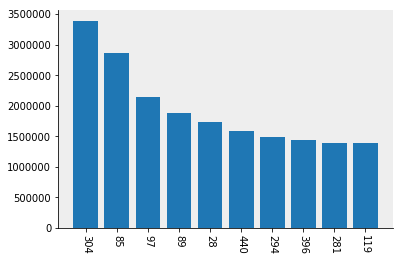

In [25]:
sorted_station_entries = grouped_by_station.sort_values(['entries'],\
                                                ascending = False)

plt.bar(range(len(sorted_station_entries.index[0:10])), \
        sorted_station_entries.entries[0:10], \
        tick_label = sorted_station_entries.index[0:10])
plt.xticks(rotation = 270)
remove_border()

In [26]:
#test = top_ten_stations[top_ten_stations.station == '125 ST']

In [27]:
#test.date_time.value_counts()

In [28]:
#plt.hist(top_ten_stations.groupby(['date_time']).sum())

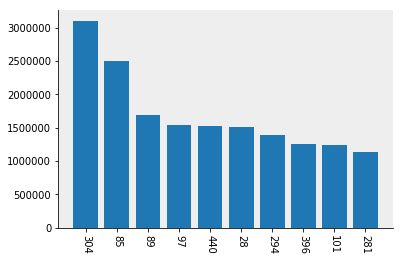

In [29]:
sorted_station_exits = grouped_by_station.sort_values(['exits'],\
                                                ascending = False)

plt.bar(range(len(sorted_station_exits.index[0:10])), \
        sorted_station_exits.exits[0:10], \
        tick_label = sorted_station_exits.index[0:10])
plt.xticks(rotation = 270)
remove_border()

Based on the plots above, it looks like the most trafficked subway stations have both the highest number of entries and exits compared to other subway stations. 

Now that we know which subway stations are most traversed, let's investigate the specific time of day to approach NYC citizens to maximize the number of people we can contact for the gala.

In order to do this, we will need to convert the strings and times into a datetime object to make plotting an easier task. This is done with the following snippet of code:

(736931.0, 736960.0)

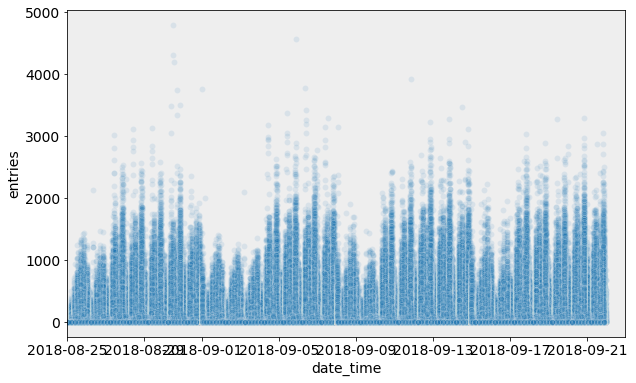

In [30]:
rcParams['figure.figsize'] = (10, 6)
rcParams['font.size'] = 14


ax = sns.scatterplot(combined_df.date_time, combined_df.entries, alpha=0.1)
plt.xlim(pd.to_datetime('2018-08-25'),pd.to_datetime('2018-09-23'))
#ax.set_xticklabels(['Week1','Week2','05-07-2018',\
        #            '05-08-2018','05-09-2018','05-10-2018','05-11-2018'], \
         #          rotation=90, ha="right")
#plt.axvline(pd.to_datetime('05-07-2018 07:30:00'), 0, .5, color='r', linewidth = 0.9)
#plt.axvline(pd.to_datetime('05-07-2018 13:00:00'), 0, .5, color='r', linewidth = 0.9)
#plt.axvline(pd.to_datetime('05-07-2018 18:00:00'), 0, .5, color='r', linewidth = 0.9)
#plt.axvline(pd.to_datetime('05-07-2018 22:00:00'), 0, .5, color='r', linewidth = 0.9)

Let's store the top ten stations into a separate data frame in order to better allocate our resources. 

In [31]:
sorted_stations = grouped_by_station.sort_values(['total'],\
                                                ascending = False)
top_ten_stations = combined_df.loc[combined_df['station'].isin(sorted_stations.index[0:10].values)]


In [32]:
top_ten_stations.station.value_counts()

Series([], Name: station, dtype: int64)

Looking at a box plot for the top ten stations, it is clear that an overwhelming majority of the total entries and exits are < 500.  This is not surprising since most hours of the day people are not using the subway relgiously (think midnight to 6am).  

In [33]:
#rcParams['figure.figsize'] = (14, 6)
#rcParams['font.size'] = 8
#sns.boxplot(top_ten_stations.station, top_ten_stations.total)

## Deeper Investigation

Now that we have done some exploratory data analysis, let's investigate other sources of data to see if we can extrapolate further analysis. 

Using the website zipatlas.com, I found information on zip codes and their populations, percentage of people with over 200k, and their female to male ratio (useful since we are trying to get women involved in technology).  

In [34]:
wealthy_df = pd.read_csv('200k.csv', header = None)

Looking at the data frame I notice a couple of things. First, we can get rid of several columns due to meaningless data.  We should also rename our columns.

In [35]:
wealthy_df.head(10)

,0,1,2,3,4,5,6
0,1,10007,"40.713973, -74.008336","New York, New York","3,522",27.04%,NaN
1,2,10162,"40.769298, -73.949942","New York, New York","1,726",24.53%,NaN
2,3,10280,"40.708501, -74.016828","New York, New York","6,614",22.94%,NaN
3,4,10282,"40.717017, -74.015566","New York, New York","1,574",22.51%,NaN
4,5,10022,"40.758615, -73.967752","New York, New York","30,642",20.20%,NaN
5,6,10024,"40.786307, -73.970694","New York, New York","61,414",19.23%,NaN
6,7,10021,"40.769742, -73.961653","New York, New York","102,078",19.05%,NaN
7,8,10028,"40.776865, -73.954721","New York, New York","44,987",18.84%,NaN
8,9,10069,"40.775551, -73.989689","New York, New York","1,403",18.41%,NaN
9,10,10023,"40.775394, -73.982197","New York, New York","62,206",16.84%,NaN


In [36]:
wealthy_df = wealthy_df.drop([0, 3, 6], axis = 1)


In [37]:
wealthy_df.columns = ['zip', 'lat_long', 'population', 'ratio_wealthy']

In [38]:
#change to a float ratio
wealthy_df['ratio_wealthy'] = wealthy_df['ratio_wealthy'].apply(lambda x: float(x.replace('%', '')) * 0.01)

In [39]:
#make zip codes immutable
wealthy_df['zip'] = wealthy_df['zip'].apply(str)

In [40]:
#convert population to integers
wealthy_df['population'] = wealthy_df['population'].apply(lambda x: int(x.replace(',', '')))

In [41]:
wealthy_df.describe()

,population,ratio_wealthy
count,44.000000,44.000000
mean,34757.204545,0.093314
std,27349.796759,0.078870
min,7.000000,0.000000
25%,14060.500000,0.016275
50%,30509.500000,0.091950
75%,56690.750000,0.153950
max,102078.000000,0.270400


In [42]:
#find the total number of wealthy people
#wealthy_df['total_wealthy'] = wealthy_df.population * wealthy_df.ratio_wealthy

In [43]:
#convert to int since we cannot have half a person
#wealthy_df['total_wealthy'] = wealthy_df.total_wealthy.apply(int)

In [44]:
wealthy_df.head(10)

,zip,lat_long,population,ratio_wealthy
0,10007,"40.713973, -74.008336",3522,0.2704
1,10162,"40.769298, -73.949942",1726,0.2453
2,10280,"40.708501, -74.016828",6614,0.2294
3,10282,"40.717017, -74.015566",1574,0.2251
4,10022,"40.758615, -73.967752",30642,0.2020
5,10024,"40.786307, -73.970694",61414,0.1923
6,10021,"40.769742, -73.961653",102078,0.1905
7,10028,"40.776865, -73.954721",44987,0.1884
8,10069,"40.775551, -73.989689",1403,0.1841
9,10023,"40.775394, -73.982197",62206,0.1684


Voila. Now our data is in a much more digestible format. It looks like our data is already sorted by the percentage of wealthy people, but it would be useful to also sort it by the total number of wealthy people, since quantity can also matter when it comes to finding enough people to donate to our gala. Let's import a couple more data frames that include the female to male ratio and average age by zip code. 

In [45]:
age_df = pd.read_csv('age.csv')

In [46]:
age_df.head()

,zip,lat_long,population,avg_age
0,10170,"40.752625, -73.975877",1,49.5
1,10171,"40.755899, -73.973858",1,48.5
2,10022,"40.758615, -73.967752","30,642",45.5
3,10044,"40.762050, -73.949933","9,520",41.0
4,10162,"40.769298, -73.949942","1,726",41.0


In [47]:
age_df['population'] = age_df['population'].apply(lambda x: int(x.replace(',', '')))

In [48]:
#age_df = age_df[age_df.population > 1000]

In [49]:
age_df['zip'] = age_df['zip'].apply(str)

In [50]:
age_df.head()

,zip,lat_long,population,avg_age
0,10170,"40.752625, -73.975877",1,49.5
1,10171,"40.755899, -73.973858",1,48.5
2,10022,"40.758615, -73.967752",30642,45.5
3,10044,"40.762050, -73.949933",9520,41.0
4,10162,"40.769298, -73.949942",1726,41.0


In [51]:
female_df = pd.read_csv('female_male_ratio.csv')

In [52]:
female_df.head()

,zip,lat_long,population,f_m_ratio
0,10048,"40.711665, -74.012417",55,3.23
1,10037,"40.813159, -73.937352","16,984",1.42
2,10021,"40.769742, -73.961653","102,078",1.28
3,10039,"40.826296, -73.937053","21,737",1.27
4,10162,"40.769298, -73.949942","1,726",1.22


In [53]:
female_df['population'] = female_df['population'].apply(lambda x: int(x.replace(',', '')))

In [54]:
female_df['zip'] = female_df['zip'].apply(str)

In [55]:
female_df.describe()

,population,f_m_ratio
count,46.000000,46.00000
mean,33247.239130,1.07500
std,27677.446261,0.40138
min,1.000000,0.00000
25%,7340.500000,0.95750
50%,28392.500000,1.10500
75%,55544.250000,1.17500
max,102078.000000,3.23000


In [56]:
age_df.describe()

,population,avg_age
count,48.000000,48.000000
mean,31861.979167,35.331250
std,27901.941473,5.161237
min,1.000000,21.300000
25%,4071.750000,32.275000
50%,26204.000000,35.050000
75%,54296.750000,38.075000
max,102078.000000,49.500000


It looks like there are slight discrepancies in the counts of each of our zip code demographic data.  We can merge these data frames to see where these are. 

In [57]:
female_df.head()

,zip,lat_long,population,f_m_ratio
0,10048,"40.711665, -74.012417",55,3.23
1,10037,"40.813159, -73.937352",16984,1.42
2,10021,"40.769742, -73.961653",102078,1.28
3,10039,"40.826296, -73.937053",21737,1.27
4,10162,"40.769298, -73.949942",1726,1.22


In [58]:
age_df.head()

,zip,lat_long,population,avg_age
0,10170,"40.752625, -73.975877",1,49.5
1,10171,"40.755899, -73.973858",1,48.5
2,10022,"40.758615, -73.967752",30642,45.5
3,10044,"40.762050, -73.949933",9520,41.0
4,10162,"40.769298, -73.949942",1726,41.0


In [59]:
merged = female_df.merge(age_df, left_on = ['zip', 'lat_long', 'population'], \
                right_on = ['zip', 'lat_long', 'population'], how = 'outer')

In [60]:
demographics = merged.merge(wealthy_df, left_on = ['zip', 'lat_long', 'population'], \
                right_on = ['zip', 'lat_long', 'population'], how = 'outer')

In [61]:
demographics = demographics.dropna()

In [62]:
demographics

,zip,lat_long,population,f_m_ratio,avg_age,ratio_wealthy
1,10037,"40.813159, -73.937352",16984,1.42,39.8,0.0081
2,10021,"40.769742, -73.961653",102078,1.28,39.9,0.1905
3,10039,"40.826296, -73.937053",21737,1.27,32.3,0.0059
4,10162,"40.769298, -73.949942",1726,1.22,41.0,0.2453
5,10028,"40.776865, -73.954721",44987,1.21,38.3,0.1884
6,10017,"40.752292, -73.972393",16201,1.21,38.0,0.1102
7,10128,"40.781656, -73.950281",59856,1.20,35.6,0.1536
8,10022,"40.758615, -73.967752",30642,1.19,45.5,0.2020
9,10030,"40.818492, -73.943283",25847,1.19,32.2,0.0119
10,10010,"40.739122, -73.982363",26408,1.19,37.6,0.1031


In [63]:
cols = list(demographics.columns)
cols[0] = 'Zip'
demographics.columns = cols
demographics.head()

,Zip,lat_long,population,f_m_ratio,avg_age,ratio_wealthy
1,10037,"40.813159, -73.937352",16984,1.42,39.8,0.0081
2,10021,"40.769742, -73.961653",102078,1.28,39.9,0.1905
3,10039,"40.826296, -73.937053",21737,1.27,32.3,0.0059
4,10162,"40.769298, -73.949942",1726,1.22,41.0,0.2453
5,10028,"40.776865, -73.954721",44987,1.21,38.3,0.1884


In [74]:
link_df = pd.read_csv('top50sta_zipcodesUpdated.csv')
link_df.head()

,Unnamed: 0,station,linename,zipcode
0,0,1 AV,L,10009
1,1,103 ST,1,10025
2,2,103 ST,6,10029
3,3,103 ST,BC,10025
4,4,103 ST-CORONA,7,11368


In [75]:
top25 = grouped_by_station.sort_values(['entries'],ascending = False)
top25 = top25.head(50)
top25

,station,linename,entries,exits,total
304,GRD CNTRL-42 ST,4567S,3391850.0,3104100.0,6495950.0
85,34 ST-HERALD SQ,BDFMNQRW,2862644.0,2500225.0,5362869.0
97,42 ST-PORT AUTH,ACENQRS1237W,2144827.0,1537856.0,3682683.0
89,34 ST-PENN STA,ACE,1875769.0,1686819.0,3562588.0
28,14 ST-UNION SQ,LNQR456W,1733708.0,1510138.0,3243846.0
440,TIMES SQ-42 ST,1237ACENQRSW,1577779.0,1532822.0,3110601.0
294,FULTON ST,2345ACJZ,1480799.0,1398023.0,2878822.0
396,PATH NEW WTC,1,1437184.0,1263574.0,2700758.0
281,FLUSHING-MAIN,7,1388380.0,1137957.0,2526337.0
119,59 ST COLUMBUS,ABCD1,1384202.0,1100576.0,2484778.0


In [78]:
top25 = top25.sort_values(by='station')
top25

,station,linename,entries,exits,total
18,125 ST,456,667268.0,605235.0,1272503.0
19,125 ST,ACBD,674369.0,579269.0,1253638.0
28,14 ST-UNION SQ,LNQR456W,1733708.0,1510138.0,3243846.0
27,14 ST-UNION SQ,456LNQRW,740287.0,656391.0,1396678.0
70,23 ST,CE,581368.0,375586.0,956954.0
71,23 ST,NRW,674996.0,360069.0,1035065.0
69,23 ST,6,788422.0,676401.0,1464823.0
83,33 ST,6,811511.0,589540.0,1401051.0
85,34 ST-HERALD SQ,BDFMNQRW,2862644.0,2500225.0,5362869.0
87,34 ST-PENN STA,123,767520.0,793948.0,1561468.0


In [ ]:
link_df.head()

In [77]:
link_df = link_df.sort_values(by='station')
link_df

,Unnamed: 0,station,linename,zipcode
0,0,1 AV,L,10009
1,1,103 ST,1,10025
2,2,103 ST,6,10029
3,3,103 ST,BC,10025
4,4,103 ST-CORONA,7,11368
5,5,104 ST,A,11417
6,6,104 ST,JZ,11418
7,7,110 ST,6,10029
8,8,111 ST,7,11368
9,9,111 ST,A,11419


In [ ]:
link_df['station'] = top25
link_df.head()

In [84]:
demographics.head()

,Zip,lat_long,population,f_m_ratio,avg_age,ratio_wealthy
1,10037,"40.813159, -73.937352",16984,1.42,39.8,0.0081
2,10021,"40.769742, -73.961653",102078,1.28,39.9,0.1905
3,10039,"40.826296, -73.937053",21737,1.27,32.3,0.0059
4,10162,"40.769298, -73.949942",1726,1.22,41.0,0.2453
5,10028,"40.776865, -73.954721",44987,1.21,38.3,0.1884


In [87]:
templist = list(demographics.columns)
templist[0] = 'zipcode'
demographics.columns = templist
demographics.head()

,zipcode,lat_long,population,f_m_ratio,avg_age,ratio_wealthy
1,10037,"40.813159, -73.937352",16984,1.42,39.8,0.0081
2,10021,"40.769742, -73.961653",102078,1.28,39.9,0.1905
3,10039,"40.826296, -73.937053",21737,1.27,32.3,0.0059
4,10162,"40.769298, -73.949942",1726,1.22,41.0,0.2453
5,10028,"40.776865, -73.954721",44987,1.21,38.3,0.1884


In [82]:
stations_and_zips = pd.merge(grouped_by_station,link_df, on='station')
stations_and_zips.head()

,station,linename_x,entries,exits,total,Unnamed: 0,linename_y,zipcode
0,1 AV,L,504631.0,555406.0,1060037.0,0,L,10009
1,103 ST,1,293324.0,150784.0,444108.0,1,1,10025
2,103 ST,1,293324.0,150784.0,444108.0,2,6,10029
3,103 ST,1,293324.0,150784.0,444108.0,3,BC,10025
4,103 ST,6,296125.0,274602.0,570727.0,1,1,10025


In [89]:
stations_and_zips['zipcode'] = stations_and_zips['zipcode'].apply(str)
full_df = pd.merge(stations_and_zips,demographics, on='zipcode')
full_df

,station,linename_x,entries,exits,total,Unnamed: 0,linename_y,zipcode,lat_long,population,f_m_ratio,avg_age,ratio_wealthy
0,1 AV,L,504631.0,555406.0,1060037.0,0,L,10009,"40.726622, -73.978955",58595,1.14,36.0,0.0222
1,103 ST,1,293324.0,150784.0,444108.0,1,1,10025,"40.797958, -73.964917",97086,1.14,36.9,0.0725
2,103 ST,1,293324.0,150784.0,444108.0,3,BC,10025,"40.797958, -73.964917",97086,1.14,36.9,0.0725
3,103 ST,6,296125.0,274602.0,570727.0,1,1,10025,"40.797958, -73.964917",97086,1.14,36.9,0.0725
4,103 ST,6,296125.0,274602.0,570727.0,3,BC,10025,"40.797958, -73.964917",97086,1.14,36.9,0.0725
5,103 ST,BC,119411.0,73867.0,193278.0,1,1,10025,"40.797958, -73.964917",97086,1.14,36.9,0.0725
6,103 ST,BC,119411.0,73867.0,193278.0,3,BC,10025,"40.797958, -73.964917",97086,1.14,36.9,0.0725
7,103 ST,1,293324.0,150784.0,444108.0,2,6,10029,"40.792245, -73.945230",75390,1.15,31.1,0.0198
8,103 ST,6,296125.0,274602.0,570727.0,2,6,10029,"40.792245, -73.945230",75390,1.15,31.1,0.0198
9,103 ST,BC,119411.0,73867.0,193278.0,2,6,10029,"40.792245, -73.945230",75390,1.15,31.1,0.0198


In [91]:
full_df.to_csv('stationdemographic.csv')

In [92]:
full_df.columns

Index(['station', 'linename_x', 'entries', 'exits', 'total', 'Unnamed: 0',
       'linename_y', 'zipcode', 'lat_long', 'population', 'f_m_ratio',
       'avg_age', 'ratio_wealthy'],
      dtype='object')

In [93]:
full_df['Rich Women'] = full_df.population * full_df.ratio_wealthy * full_df.f_m_ratio / 2
full_df = full_df.sort_values(by='Rich Women', ascending = False)
full_df

,station,linename_x,entries,exits,total,Unnamed: 0,linename_y,zipcode,lat_long,population,f_m_ratio,avg_age,ratio_wealthy,Rich Women
1,103 ST,1,293324.0,150784.0,444108.0,1,1,10025,"40.797958, -73.964917",97086,1.14,36.9,0.0725,4012.078950
2,103 ST,1,293324.0,150784.0,444108.0,3,BC,10025,"40.797958, -73.964917",97086,1.14,36.9,0.0725,4012.078950
3,103 ST,6,296125.0,274602.0,570727.0,1,1,10025,"40.797958, -73.964917",97086,1.14,36.9,0.0725,4012.078950
4,103 ST,6,296125.0,274602.0,570727.0,3,BC,10025,"40.797958, -73.964917",97086,1.14,36.9,0.0725,4012.078950
5,103 ST,BC,119411.0,73867.0,193278.0,1,1,10025,"40.797958, -73.964917",97086,1.14,36.9,0.0725,4012.078950
6,103 ST,BC,119411.0,73867.0,193278.0,3,BC,10025,"40.797958, -73.964917",97086,1.14,36.9,0.0725,4012.078950
58,14 ST-UNION SQ,LNQR456W,1733708.0,1510138.0,3243846.0,27,456LNQRW,10003,"40.731856, -73.989145",53673,1.06,33.7,0.1091,3103.533879
59,14 ST-UNION SQ,LNQR456W,1733708.0,1510138.0,3243846.0,28,LNQR456W,10003,"40.731856, -73.989145",53673,1.06,33.7,0.1091,3103.533879
57,14 ST-UNION SQ,456LNQRW,740287.0,656391.0,1396678.0,28,LNQR456W,10003,"40.731856, -73.989145",53673,1.06,33.7,0.1091,3103.533879
56,14 ST-UNION SQ,456LNQRW,740287.0,656391.0,1396678.0,27,456LNQRW,10003,"40.731856, -73.989145",53673,1.06,33.7,0.1091,3103.533879


In [104]:
top5 = full_df['station'].unique()[0:10]
top5
#results here are different from before...

array(['103 ST', '14 ST-UNION SQ', '14 ST', '14TH STREET', '110 ST',
       '1 AV', '125 ST', '175 ST', '168 ST', '157 ST'], dtype=object)